<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Library import</h2>
</div>

In [248]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import linear_model
import warnings
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, precision_score, recall_score, log_loss
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [249]:
warnings.filterwarnings('ignore')

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Dataset Features</h2>
</div>

1. **ph**: pH of 1. water (0 to 14).

2. **Hardness**: Capacity of water to precipitate soap in mg/L.

3. **Solids**: Total dissolved solids in ppm.

4. **Chloramines**: Amount of Chloramines in ppm.

5. **Sulfate**: Amount of Sulfates dissolved in mg/L.

6. **Conductivity**: Electrical conductivity of water in μS/cm.

7. **Organic_carbon**: Amount of organic carbon in ppm.

8. **Trihalomethanes**: Amount of Trihalomethanes in μg/L.

9. **Turbidity**: Measure of light emiting property of water in NTU.

10. **Potability**: Indicates if water is safe for human consumption. Potable - 1 and Not potable - 0

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Load and analyse data</h2>
</div>

In [250]:
df = pd.read_csv("data/water_potability.csv")
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [251]:
df.shape

(3276, 10)

In [252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


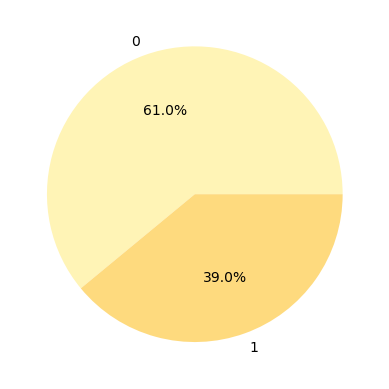

In [253]:
plt.pie(df.Potability.value_counts(), labels = ["0", "1"], colors = sns.color_palette("YlOrBr"), autopct = '%1.1f%%');

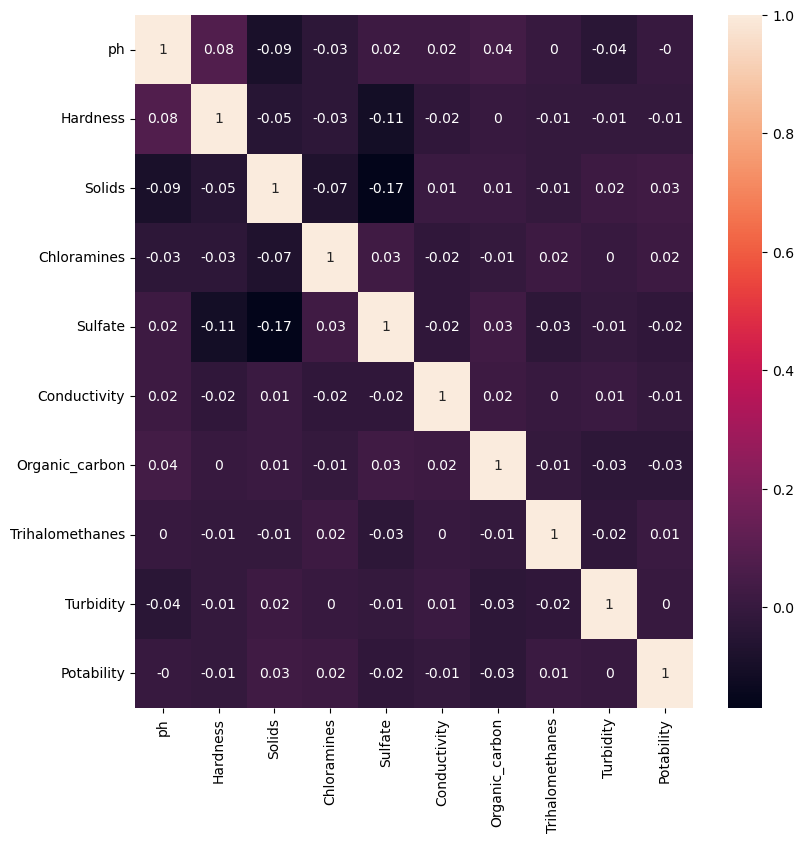

In [254]:
df_corr = df.corr()
df_corr = df_corr.apply(lambda x: round(x, 2))
fig, ax = plt.subplots(figsize = (9,9))
sns.heatmap(data=df_corr, annot=True, ax=ax);

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Missing data visualization</h2>
</div>

In [255]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [256]:
df.isnull().mean()*100 

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

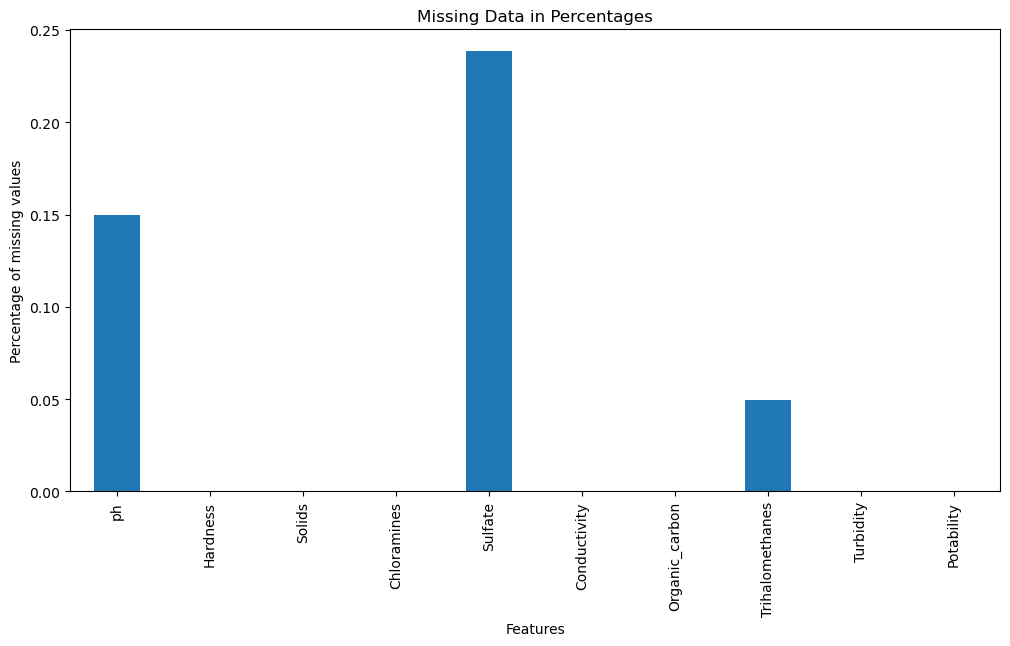

In [257]:
df.isnull().mean().plot.bar(figsize=(12,6)) 
plt.ylabel('Percentage of missing values') 
plt.xlabel('Features') 
plt.title('Missing Data in Percentages');

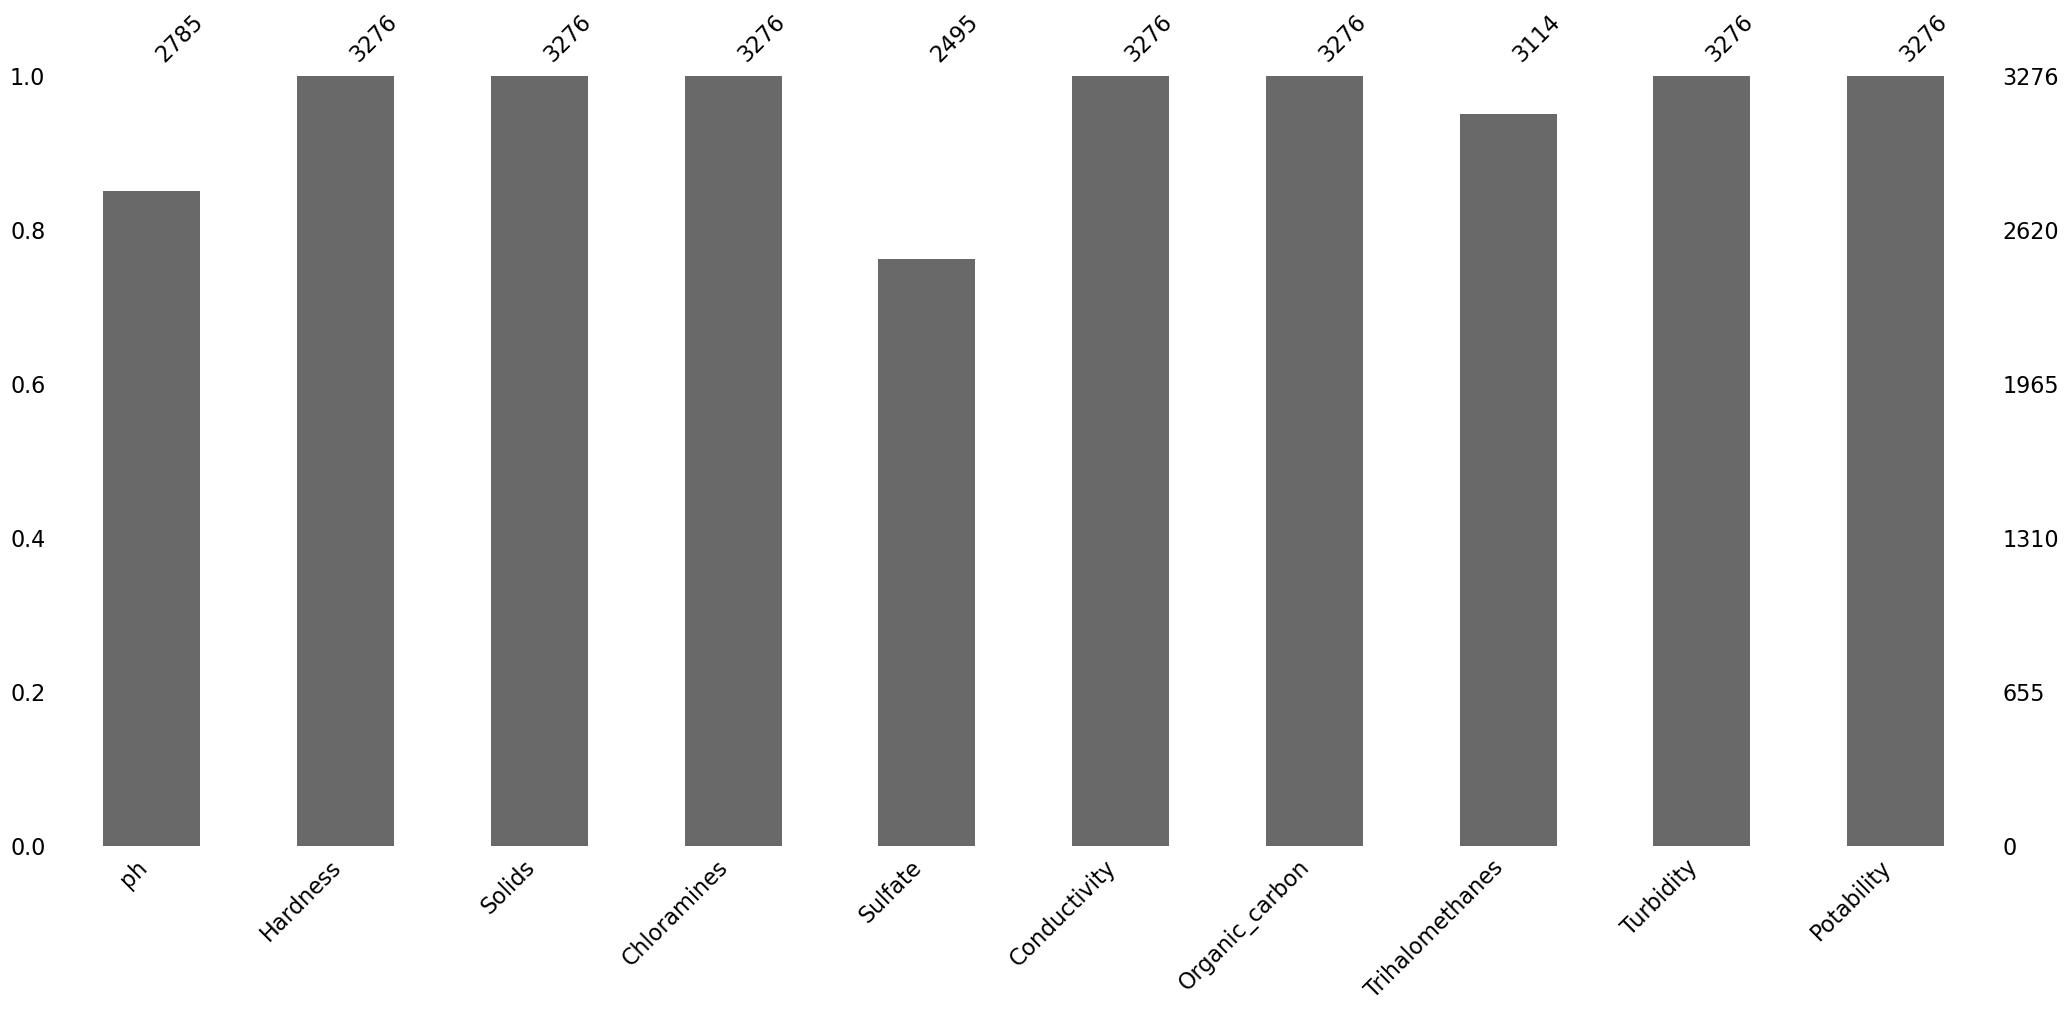

In [258]:
msno.bar(df);

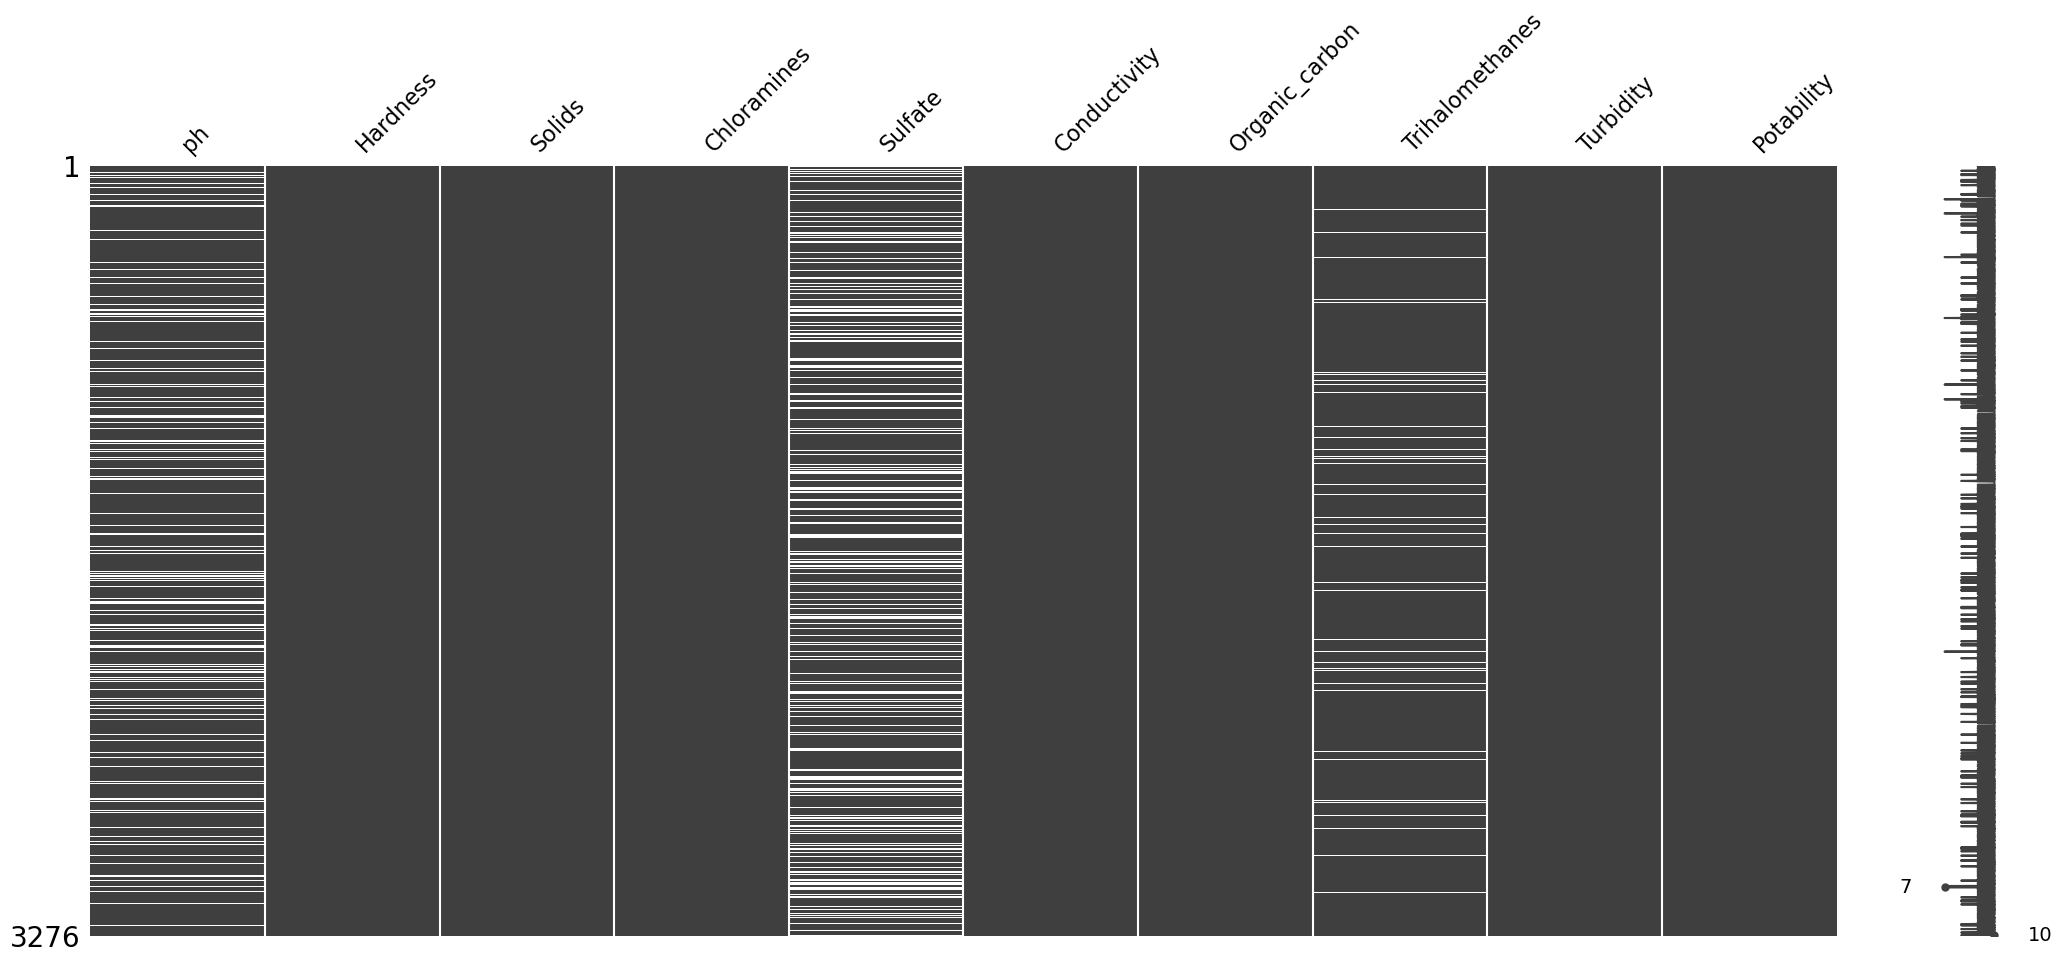

In [259]:
msno.matrix(df);

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Train-test split</h2>
</div>

In [260]:
np.random.seed(42)
X = df.drop('Potability', axis=1)
y = df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

X_train.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
233,6.623614,203.030141,17167.301297,6.049601,311.726288,410.243247,15.914500,65.021229,2.915166
831,6.684700,193.840931,34157.184474,9.876574,344.535407,498.063996,8.818757,66.659352,4.030660
2658,6.836060,205.667718,18321.327502,6.712854,297.837188,494.484249,13.808923,70.714225,4.952508
2495,NaN,183.488839,12675.938962,9.777807,319.870584,482.445026,13.309723,46.853410,3.240419
2603,6.406798,182.885137,17851.064021,7.462758,332.486731,398.779746,17.301617,64.070236,4.573968


In [261]:
X_train.isnull().mean()*100

ph                 15.076336
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            24.083969
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.847328
Turbidity           0.000000
dtype: float64

In [262]:
X_test.isnull().mean()*100

ph                 14.634146
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            22.865854
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     5.335366
Turbidity           0.000000
dtype: float64

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Deletion</h2>
</div>

In [263]:
X_train_del = X_train.dropna()
X_test_del = X_test.dropna()
idx = X_train_del.index
y_train_del = y_train.loc[idx]
idx = X_test_del.index
y_test_del = y_test.loc[idx]
print(f'Pre izbacivanja podataka imamo {df.shape[0]} instanci')

df_listwise = df.dropna()
print(f'Posle izbacivanja podataka imamo {df_listwise.shape[0]} instanci')

# to see how mnay instances we have lost
print(f'Izgubili smo {df.shape[0]-df_listwise.shape[0]} instanci, sto znaci %{round((df.shape[0]-df_listwise.shape[0])/ (float(df.shape[0])),2)*100} podataka je izgubljeno')

Pre izbacivanja podataka imamo 3276 instanci
Posle izbacivanja podataka imamo 2011 instanci
Izgubili smo 1265 instanci, sto znaci %39.0 podataka je izgubljeno


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Mean imputation</h2>
</div>

In [264]:
imputer = SimpleImputer(strategy='mean')

imputer.fit(X_train)

X_train_mean = imputer.transform(X_train)

X_test_mean = imputer.transform(X_test)

In [265]:
X_train_mean_df = pd.DataFrame(data=X_train_mean, columns=X.columns)

X_train_mean_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,6.623614,203.030141,17167.301297,6.049601,311.726288,410.243247,15.914500,65.021229,2.915166
1,6.684700,193.840931,34157.184474,9.876574,344.535407,498.063996,8.818757,66.659352,4.030660
2,6.836060,205.667718,18321.327502,6.712854,297.837188,494.484249,13.808923,70.714225,4.952508
3,7.088976,183.488839,12675.938962,9.777807,319.870584,482.445026,13.309723,46.853410,3.240419
4,6.406798,182.885137,17851.064021,7.462758,332.486731,398.779746,17.301617,64.070236,4.573968


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Median imputation</h2>
</div>

In [266]:
imputer = SimpleImputer(strategy='median')

imputer.fit(X_train)

X_train_median = imputer.transform(X_train)

X_test_median = imputer.transform(X_test)

In [267]:
X_train_median_df = pd.DataFrame(data=X_train_median, columns=X.columns)

X_train_median_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,6.623614,203.030141,17167.301297,6.049601,311.726288,410.243247,15.914500,65.021229,2.915166
1,6.684700,193.840931,34157.184474,9.876574,344.535407,498.063996,8.818757,66.659352,4.030660
2,6.836060,205.667718,18321.327502,6.712854,297.837188,494.484249,13.808923,70.714225,4.952508
3,7.021617,183.488839,12675.938962,9.777807,319.870584,482.445026,13.309723,46.853410,3.240419
4,6.406798,182.885137,17851.064021,7.462758,332.486731,398.779746,17.301617,64.070236,4.573968


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Hot-deck imputation</h2>
</div>

In [268]:
imputer = SimpleImputer(strategy='most_frequent')

imputer.fit(X_train)

X_train_hd = imputer.transform(X_train)

X_test_hd = imputer.transform(X_test)

In [269]:
X_train_hd_df = pd.DataFrame(data=X_train_hd, columns=X.columns)

X_train_hd_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,6.623614,203.030141,17167.301297,6.049601,311.726288,410.243247,15.914500,65.021229,2.915166
1,6.684700,193.840931,34157.184474,9.876574,344.535407,498.063996,8.818757,66.659352,4.030660
2,6.836060,205.667718,18321.327502,6.712854,297.837188,494.484249,13.808923,70.714225,4.952508
3,0.000000,183.488839,12675.938962,9.777807,319.870584,482.445026,13.309723,46.853410,3.240419
4,6.406798,182.885137,17851.064021,7.462758,332.486731,398.779746,17.301617,64.070236,4.573968


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Regression imputation</h2>
</div>

In [270]:
imputer = IterativeImputer(estimator=LinearRegression(), max_iter=1)

imputer.fit(X_train)

X_train_reg = imputer.transform(X_train)

X_test_reg = imputer.transform(X_test)

In [271]:
X_train_reg_df = pd.DataFrame(data=X_train_reg, columns=X.columns)

X_train_reg_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,6.623614,203.030141,17167.301297,6.049601,311.726288,410.243247,15.914500,65.021229,2.915166
1,6.684700,193.840931,34157.184474,9.876574,344.535407,498.063996,8.818757,66.659352,4.030660
2,6.836060,205.667718,18321.327502,6.712854,297.837188,494.484249,13.808923,70.714225,4.952508
3,7.124336,183.488839,12675.938962,9.777807,319.870584,482.445026,13.309723,46.853410,3.240419
4,6.406798,182.885137,17851.064021,7.462758,332.486731,398.779746,17.301617,64.070236,4.573968


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
KNN imputation</h2>
</div>

In [272]:
imputer = KNNImputer(n_neighbors=5)

imputer.fit(X_train)

X_train_knn = imputer.transform(X_train)

X_test_knn = imputer.transform(X_test)

In [273]:
X_train_knn_df = pd.DataFrame(data=X_train_knn, columns=X.columns)

X_train_knn_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,6.623614,203.030141,17167.301297,6.049601,311.726288,410.243247,15.914500,65.021229,2.915166
1,6.684700,193.840931,34157.184474,9.876574,344.535407,498.063996,8.818757,66.659352,4.030660
2,6.836060,205.667718,18321.327502,6.712854,297.837188,494.484249,13.808923,70.714225,4.952508
3,7.598431,183.488839,12675.938962,9.777807,319.870584,482.445026,13.309723,46.853410,3.240419
4,6.406798,182.885137,17851.064021,7.462758,332.486731,398.779746,17.301617,64.070236,4.573968


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
MICE imputation</h2>
</div>

In [274]:
imputer = IterativeImputer(estimator=LinearRegression(), random_state=42, max_iter=20)

imputer.fit(X_train)

X_train_mice = imputer.transform(X_train)

X_test_mice = imputer.transform(X_test)

In [275]:
X_train_mice_df = pd.DataFrame(data=X_train_mice, columns=X.columns)

X_train_mice_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,6.623614,203.030141,17167.301297,6.049601,311.726288,410.243247,15.914500,65.021229,2.915166
1,6.684700,193.840931,34157.184474,9.876574,344.535407,498.063996,8.818757,66.659352,4.030660
2,6.836060,205.667718,18321.327502,6.712854,297.837188,494.484249,13.808923,70.714225,4.952508
3,7.124336,183.488839,12675.938962,9.777807,319.870584,482.445026,13.309723,46.853410,3.240419
4,6.406798,182.885137,17851.064021,7.462758,332.486731,398.779746,17.301617,64.070236,4.573968


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Standardizacija podataka</h2>
</div>

In [276]:
#Standardizacija nad deletion
scaler = StandardScaler()
scaler.fit(X_train_del)

X_train_del_std = pd.DataFrame(scaler.transform(X_train_del), columns=X_train_del.columns)
X_test_del_std = pd.DataFrame(scaler.transform(X_test_del), columns=X_test_del.columns)

#Standardizacija nad mean imputation
scaler = StandardScaler()
scaler.fit(X_train_mean_df)

X_train_mean_std = pd.DataFrame(scaler.transform(X_train_mean_df), columns=X_train_mean_df.columns)
X_test_mean_std = pd.DataFrame(scaler.transform(X_test_mean), columns=X_train_mean_df.columns)

#Standardizacija nad median imputation
scaler = StandardScaler()
scaler.fit(X_train_median_df)

X_train_median_std = pd.DataFrame(scaler.transform(X_train_median_df), columns=X_train_median_df.columns)
X_test_median_std = pd.DataFrame(scaler.transform(X_test_median), columns=X_train_median_df.columns)

#Standardizacija nad hot-deck imputation
scaler = StandardScaler()
scaler.fit(X_train_hd_df)

X_train_hd_std = pd.DataFrame(scaler.transform(X_train_hd_df), columns=X_train_hd_df.columns)
X_test_hd_std = pd.DataFrame(scaler.transform(X_test_hd), columns=X_train_hd_df.columns)

#Standardizacija nad jednostrukom regresijom
scaler = StandardScaler()
scaler.fit(X_train_reg_df)

X_train_reg_std = pd.DataFrame(scaler.transform(X_train_reg_df), columns=X_train_reg_df.columns)
X_test_reg_std = pd.DataFrame(scaler.transform(X_test_reg), columns=X_train_reg_df.columns)

#Standardizacija nad jednostrukom knn imputacijom
scaler = StandardScaler()
scaler.fit(X_train_knn_df)

X_train_knn_std = pd.DataFrame(scaler.transform(X_train_knn_df), columns=X_train_knn_df.columns)
X_test_knn_std = pd.DataFrame(scaler.transform(X_test_knn), columns=X_train_knn_df.columns)


#Standardizacija nad jednostrukom mice imputacijom
scaler = StandardScaler()
scaler.fit(X_train_mice_df)

X_train_mice_std = pd.DataFrame(scaler.transform(X_train_mice_df), columns=X_train_mice_df.columns)
X_test_mice_std = pd.DataFrame(scaler.transform(X_test_mice), columns=X_train_mice_df.columns)

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Primena klasifikacionih modela masinskog ucenja</h2>
</div>

In [277]:
testing = pd.DataFrame(columns=["Algoritam","Imputacija/Brisanje", "Kombinovana f mera", "Područje ispod ROC krive", "Accuracy"])
testing

,Algoritam,Imputacija/Brisanje,Kombinovana f mera,Područje ispod ROC krive,Accuracy


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Random Forest Classifier, kreiranje modela</h2>
</div>

In [278]:
y_train_del.shape, X_train_del_std.shape

((1598,), (1598, 9))

In [279]:
np.random.seed(42)
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)
# Podešavanje hiperparametara i kreiranje modela
params = {
            "n_estimators" : [100, 200], 
            "criterion" : ["gini", "entropy"], 
            "max_depth" : [15, 25, None],
            "min_samples_split" : [3, 6], 
            "min_samples_leaf" : [2, 4]
}

#Model za izbrisane podatke
model_del = GridSearchCV(estimator = RandomForestClassifier(class_weight = "balanced", n_jobs = -1, random_state=42), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_del.fit(X_train_del_std, y_train_del)

#Model za mean
model_mean = GridSearchCV(estimator = RandomForestClassifier(class_weight = "balanced", n_jobs = -1, random_state=42), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_mean.fit(X_train_mean_std, y_train)

#Model za median
model_median = GridSearchCV(estimator = RandomForestClassifier(class_weight = "balanced", n_jobs = -1, random_state=42), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_median.fit(X_train_median_std, y_train)

#Model za jednostruku imputaciju pomocu regresije
model_reg = GridSearchCV(estimator = RandomForestClassifier(class_weight = "balanced", n_jobs = -1, random_state=42), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_reg.fit(X_train_reg_std, y_train)

#Model za jednostruku imputaciju pomocu knn
model_knn = GridSearchCV(estimator = RandomForestClassifier(class_weight = "balanced", n_jobs = -1, random_state=42), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_knn.fit(X_train_knn_std, y_train)

#Model za mice
model_mice = GridSearchCV(estimator = RandomForestClassifier(class_weight = "balanced", n_jobs = -1, random_state=42), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_mice.fit(X_train_mice_std, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [15, 25, None],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [3, 6],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [280]:
roc_aucs = []
f1_mera = []
accs = []

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Deletion</h2>
</div>

In [281]:
pred = model_del.predict(X_test_del_std)
f1 = f1_score(y_test_del, model_del.predict(X_test_del_std))
auc = roc_auc_score(y_test_del, model_del.predict(X_test_del_std))
acc = accuracy_score(y_test_del, model_del.predict(X_test_del_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

testing.loc[-1] = ["Random Forest bez podešavanja hiperparametara","Brisanje", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

Kombinovana F mera je : 0.539
Podrucje ispod ROC krive je: 0.647
Accuracy je: 0.685


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Mean imputation</h2>
</div>

In [282]:
pred = model_mean.predict(X_test_mean_std)
f1 = f1_score(y_test, model_mean.predict(X_test_mean_std))
auc = roc_auc_score(y_test, model_mean.predict(X_test_mean_std))
acc = accuracy_score(y_test, model_mean.predict(X_test_mean_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

testing.loc[-1] = ["Random Forest bez podešavanja hiperparametara","Mean imputacija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

Kombinovana F mera je : 0.465
Podrucje ispod ROC krive je: 0.616
Accuracy je: 0.677


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Median imputation</h2>
</div>

In [283]:
pred = model_median.predict(X_test_median_std)
f1 = f1_score(y_test, model_median.predict(X_test_median_std))
auc = roc_auc_score(y_test, model_median.predict(X_test_median_std))
acc = accuracy_score(y_test, model_median.predict(X_test_median_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

testing.loc[-1] = ["Random Forest bez podešavanja hiperparametara","Median imputacija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

Kombinovana F mera je : 0.446
Podrucje ispod ROC krive je: 0.607
Accuracy je: 0.671


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Jednostruka regresija</h2>
</div>

In [284]:
pred = model_reg.predict(X_test_reg_std)
f1 = f1_score(y_test, model_reg.predict(X_test_reg_std))
auc = roc_auc_score(y_test, model_reg.predict(X_test_reg_std))
acc = accuracy_score(y_test, model_reg.predict(X_test_reg_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

testing.loc[-1] = ["Random Forest bez podešavanja hiperparametara","Jednostruka regresija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

Kombinovana F mera je : 0.501
Podrucje ispod ROC krive je: 0.632
Accuracy je: 0.684


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
KNN</h2>
</div>

In [285]:
pred = model_knn.predict(X_test_knn_std)
f1 = f1_score(y_test, model_knn.predict(X_test_knn_std))
auc = roc_auc_score(y_test, model_knn.predict(X_test_knn_std))
acc = accuracy_score(y_test, model_knn.predict(X_test_knn_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

testing.loc[-1] = ["Random Forest bez podešavanja hiperparametara","KNN imputacija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

Kombinovana F mera je : 0.445
Podrucje ispod ROC krive je: 0.610
Accuracy je: 0.677


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
MICE</h2>
</div>

In [286]:
pred = model_mice.predict(X_test_mice_std)
f1 = f1_score(y_test, model_mice.predict(X_test_mice_std))
auc = roc_auc_score(y_test, model_mice.predict(X_test_mice_std))
acc = accuracy_score(y_test, model_mice.predict(X_test_mice_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

testing.loc[-1] = ["Random Forest bez podešavanja hiperparametara","MICE imputacija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

Kombinovana F mera je : 0.501
Podrucje ispod ROC krive je: 0.632
Accuracy je: 0.684


In [287]:
testing

,Algoritam,Imputacija/Brisanje,Kombinovana f mera,Područje ispod ROC krive,Accuracy
0,Random Forest bez podešavanja hiperparametara,MICE imputacija,0.501205,0.631804,0.684451
1,Random Forest bez podešavanja hiperparametara,KNN imputacija,0.445026,0.609860,0.676829
2,Random Forest bez podešavanja hiperparametara,Jednostruka regresija,0.501205,0.631804,0.684451
3,Random Forest bez podešavanja hiperparametara,Median imputacija,0.446154,0.606677,0.670732
4,Random Forest bez podešavanja hiperparametara,Mean imputacija,0.464646,0.615709,0.676829
5,Random Forest bez podešavanja hiperparametara,Brisanje,0.539007,0.647129,0.685230


Razlog za ovo je verovatno taj sto podaci nisu dovoljno korelisani

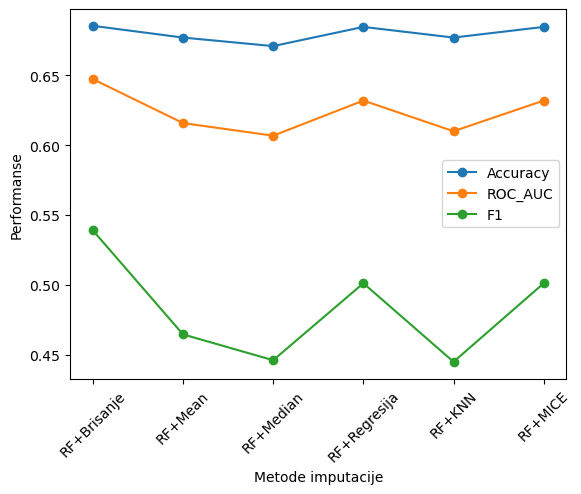

In [288]:
metode = ['RF+Brisanje', 'RF+Mean', 'RF+Median', 'RF+Regresija', 'RF+KNN', 'RF+MICE']

plt.plot(metode, accs, marker='o', label='Accuracy')
plt.plot(metode, roc_aucs, marker='o', label='ROC_AUC')
plt.plot(metode, f1_mera, marker='o', label='F1')
plt.xlabel("Metode imputacije")
plt.ylabel("Performanse")
plt.xticks(rotation=45) 
plt.legend()
plt.show()